In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.integrate import solve_ivp

We will write the equation of an integrate and fire neuron and solve it numerically with Runge-Kutta 4th order. The equation of motion we will use is the one descibed in [the seminal paper by Hopfield and Tank, 1985](http://genomics.princeton.edu/tank/pdf-publications/neural%20computation%20of%20decisions%20in%20optimization,%20Hopfiedl%20&%20Tank.pdf):

$$C_{i} \dfrac{du_{i}}{dt} = \sum_{j=1}^{N} T_{ij} V_{j} - \dfrac{u_{i}}{R_{i}} + I_{i}$$


With $ V_{j} = g_{i}(u_{j})$

This is, $ V_{j} $ is the result of a non-linear transformation of the state of neuron $ j $ &mdash; in other words its the somatic membrane voltage &mdash; and resembles the dynamics of the state variable being propagated from the soma to the presynaptic terminal (like a cable) and being converted into release units.


For simplicity, and as in Tank and Hopfield's orginal '85 paper we will consider a set of neurons with exactly the same biophysical properties, namely $g_{i} = g$ , $R_{i} = R$ and $ C_{i} = C $ for all $ i $ neurons in the network. We will also denote $ I_{i} / C $,  $ T_{ij} / C $ as $ I_{i} $ and $ T_{ij} $, respectively. If we divide by $C$ the previous equation we obtain:


$$\dfrac{du_{i}}{dt} = - \dfrac{u_{i}}{\tau} + \sum_{j=1}^{N} T_{ij} V_{j} + I_{i}$$

where the membrane constant $ \tau = RC $.

We will define the function $g$ as a sigmoid monotonic:

$$ g(u) = \dfrac{1}{1 + e^{-u}} $$

Our artificial neurons are lacking many components present in biological ones and are a very burd description of them. But for the moment we will just implement them like this, and later on we will add other components like spikes or refractory period.

This model is so simple that we don't even need numerical integration. We can just solve the first order ODE analitically as a series by making some small assumptions like $ \sum_{j=1}^{N} T_{ij} V_{j} + I_{i} $ is constant in our integration steps $ dt $ which holds true if we chose an integration step small enough. The series for the equation of motion is:

$$u_{i}^{(t+1)} = - \left(\sum_{j=1}^{N} T_{ij} V_{j} + I_{i}\right) + \left(\sum_{j=1}^{N} T_{ij} V_{j} + I_{i} + u_{i}^{(t)}\right) e^{-\Delta t / \tau} $$

Or, reorganizing term and substituting $V_{j}$ for its complete expression:

$$u_{i}^{(t+1)} =  u_{i}^{(t)} e^{-\Delta t / \tau} + \left(\sum_{j=1}^{N} T_{ij} \ g(u_{j}) + I_{i}\right) \left(e^{-\Delta t / \tau} - 1\right) $$

Basically, this equation shows that after each integration step the membrane potential decreases exponentially with a time constant of $\tau$.

In [72]:
# for one neuron only with a 100 inputs and a time decay constant of 5

# parameters

n_neurons = 1
n_inputs = 100
tau = 10
I = 1
T = np.random.random_sample(size=[n_neurons, n_inputs])
V = np.random.random_sample(size=[n_inputs])

# initial conditions

u_0 = 0

# equation of motion

def neuron(t, u, I=0.1):
    
    if t > 100:
        I = 0
    
    return [- u / tau + I]

In [73]:
sol = solve_ivp(neuron, [0, 1000], [10], dense_output=True)

In [74]:
t = np.linspace(0, 1000, 1000)
recording = sol.sol(t)

In [144]:
last_time = 500
u=0
delta_t = 0.1
tau = 5
I = np.zeros(int(last_time*(1/delta_t)))
I[0:int(100*(1/delta_t))] = 0.07
I[1000:1500] = 0.1
recording = np.zeros_like(I)
n_refr = 0

for n_step, time in enumerate(np.arange(0, last_time, delta_t)):
    
    if n_refr > 0:
        n_refr += 1
        u = 0
        
    if n_refr*delta_t > 10:
        n_refr= 0
        
    if n_refr == 0:
        u = u*math.exp(-delta_t/tau) + I[n_step]*(math.exp(-delta_t/tau) - 1)
    
    if u < -0.09:
        u=0
        n_refr = 1
        
    recording[n_step] = u

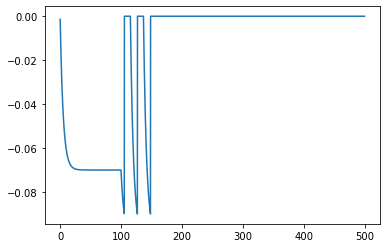

In [145]:
sns.lineplot(x=np.linspace(0, last_time, int(last_time/delta_t)), y=recording)

In [146]:
sns.scatterplot(x=t, y=np.squeeze(recording.T))

ValueError: arrays must all be same length

We now need to define what happens when a neuron fires an action potential. We will do so based on the following definition which can be found in the book [Neuronal dynamics by Gerstner, Kistler, Naud and Paninski](https://neuronaldynamics.epfl.ch/online/Ch1.S3.html), by setting a firing threshold $\vartheta$:

$$ t^{(f)} : u \left( t^{(f)} \right) = \vartheta $$

Spike $ f $ will occur at time $ t^{(f)} $. And we will set the state variable to a new value $ u_{r} $ after firing occurs:

$$ \lim_{\delta \to 0; \delta > 0} u \left(t^{(f)} + \delta \right) = u_{r} $$

Where $ \delta $ is the Dirac delta function. Finally we can write the spike train of a neuron as:

$$ S_{i} (t) = \sum_{f} \delta \left(t - t_{i}^{(f)} \right) $$

## Take 2: Bellec et al. 2020 BioRxiv

In [37]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
def heaviside(x):
    if x < 0:
        return 0
    if x >= 0:
        return 1

def neuron_step(v, I, refractory, delta_t=1, tau_m=20, v_th=40, v_rest=0, noise_level=2, refractory_time=4):
    alpha = exp(-delta_t/tau_m)
    z = heaviside(v-v_th+v_rest)
    if z == 1:
        refractory = 0
    if 1 < refractory <= refractory_time:
        z = 0
    refractory += 1
    new_v = alpha*v + I - z*v_th + noise_level*np.random.randn()
    return new_v, refractory, z

In [444]:
duration = 2000
I = np.zeros(duration)
I[100:200] = 8
I[200:400] = 0
I[400:600] = 8
I[800:1000] = -4
I[1000:1100] = 8
recording = np.zeros_like(I)
spiking_history = np.zeros_like(I)
v = 0
refractory=4
v_rest = -70

for time in np.arange(0, duration):
    v, refractory, z = neuron_step(v, I[time], refractory, v_rest=v_rest)
    recording[time] = v
    spiking_history[time] = z    

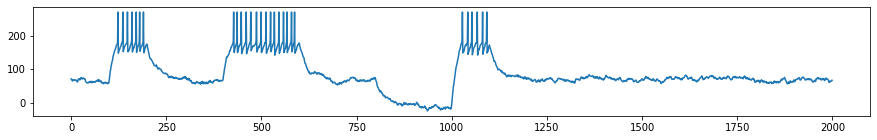

In [445]:
plt.figure(1, figsize=(15,2))
plt.plot(np.arange(0,duration), recording + (200-recording)*spiking_history - v_rest)

In [40]:
duration = 2000
I = np.zeros(duration)
I[100:200] = 4
I[200:400] = -2
I[400:600] = 4
I[800:1500] = 0
recording = np.zeros_like(I)
spiking_history = np.zeros_like(I)
v = 0
refractory=4
v_rest=0

for time in np.arange(0, duration):
    v, refractory, z = neuron_step(v, I[time], refractory, noise_level=5)
    recording[time] = v
    spiking_history[time] = z    

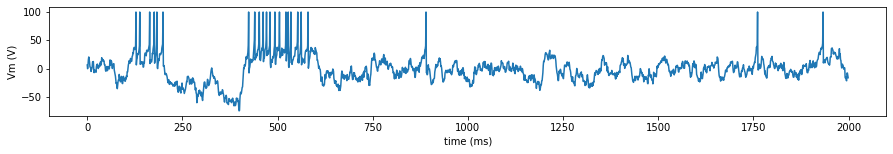

In [41]:
plt.figure(1, figsize=(15,2))
plt.plot(np.arange(0,duration), recording + (100-recording)*spiking_history - v_rest)
plt.xlabel("time (ms)")
plt.ylabel("Vm (V)")
plt.savefig("exp001.jpg")

In [58]:
class neuron:
    def __init__(self, tau_m=20, v_th=40, v_rest=0, noise_level=2, refractory_time=4):
        self.tau_m = tau_m
        self.v_th = v_th
        self.v_rest = v_rest
        self.basal_noise = basal_noise
        self.refractory_time = refractory_time
        
        self.vm = 0
        self.refractory_counter = 4
        self.state = (self.vm, self.refractory_counter)
        
        self.recording = None
        self.spiking_history = None
        
    @staticmethod
    def heaviside(x):
        if x < 0:
            return 0
        if x >= 0:
            return 1
        
    def simulate_step(self, I_external, delta_t=1):
        alpha = exp(-delta_t/self.tau_m)
        has_fired = heaviside(v-self.v_th+self.v_rest)
        
        if has_fired == 1:
            self.refractory_counter = 0
        if 1 < self.refractory_counter <= self.refractory_time:
            has_fired = 0
            self.refractory_counter += 1
            
        new_vm = alpha*v + I_external - z*self.v_th + self.basal_noise*np.random.randn()
        
        if spiking_history:
            np.append(self.spiking_history, has_fired)
        else:
            spiking_history = np.array([has_fired])
        
        return (new_vm, refractory_counter), has_fired
    
    def simple_plot(self, spike_height=100):
        plt.figure(1, figsize=(15,2))
        plt.plot(np.arange(0,len(self.recording)), self.recording + (spike_height-self.recording)*self.spiking_history - self.v_rest)
        plt.xlabel("time (ms)")
        plt.ylabel("Vm (V)")
        plt.savefig("exp001.jpg")

IndentationError: expected an indented block (<ipython-input-58-ba2628b4af0f>, line 18)

In [59]:
class recurrent_layer(neuron):
    def __init__(self):
        pass
    
    def 
        
    

SyntaxError: unexpected EOF while parsing (<ipython-input-59-3dd7aef22c1d>, line 2)